In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
plt.rc('font', family='SimHei', size=13)

import os,gc,re,warnings,sys
warnings.filterwarnings("ignore")



In [2]:
train_user_df = pd.read_csv('../underexpose_train/underexpose_user_feat.csv', names=['user_id','user_age_level','user_gender','user_city_level'])
train_item_df = pd.read_csv('../underexpose_train/underexpose_item_feat.csv')
train_click_0_df = pd.read_csv('../underexpose_train/underexpose_train_click-0.csv',names=['user_id','item_id','time'])

In [3]:
train_item_df.columns = ['item_id'] + ['txt_vec'+str(i) for i in range(128)] + ['img_vec'+str(i) for i in range(128)]
train_item_df['txt_vec0'] = train_item_df['txt_vec0'].apply(lambda x:float(x[1:]))
train_item_df['txt_vec127'] = train_item_df['txt_vec127'].apply(lambda x:float(x[:-1]))
train_item_df['img_vec0'] = train_item_df['img_vec0'].apply(lambda x:float(x[1:]))
train_item_df['img_vec127'] = train_item_df['img_vec127'].apply(lambda x:float(x[:-1]))

# rank
train_click_0_df['rank'] = train_click_0_df.groupby(['user_id'])['time'].rank(ascending=False).astype(int)

# click cnts
train_click_0_df['click_cnts'] = train_click_0_df.groupby(['user_id'])['time'].transform('count')

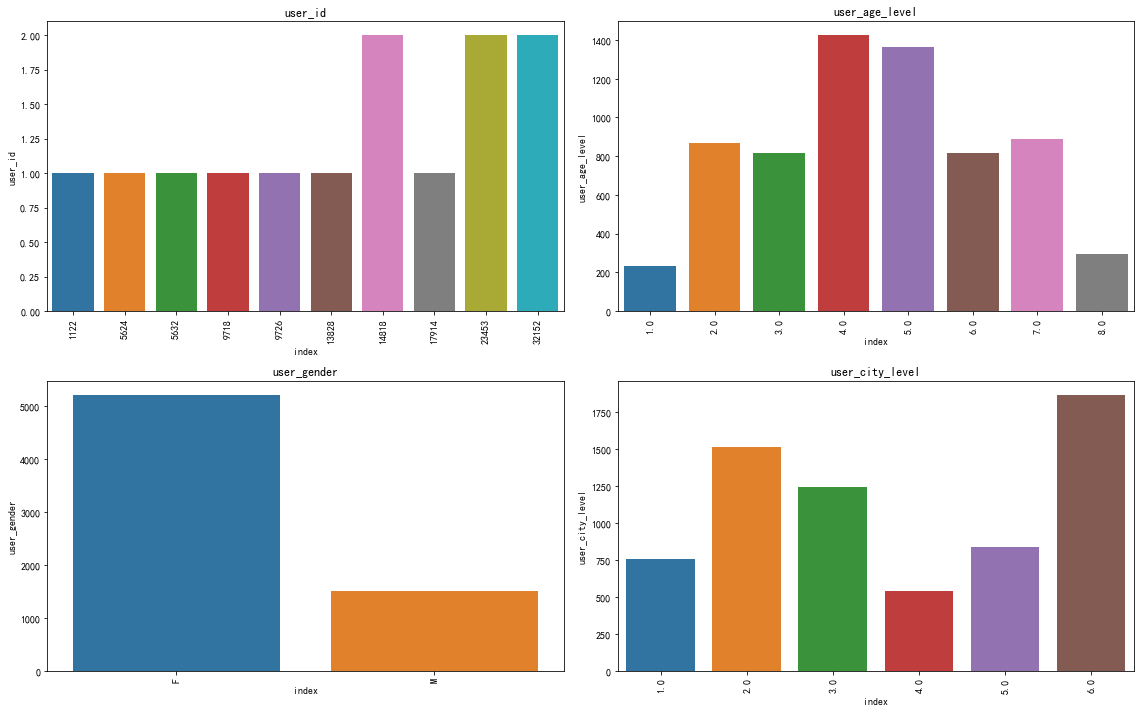

In [4]:
plt.figure()
plt.figure(figsize=(16, 10))
i = 1
for col in ['user_id', 'user_age_level', 'user_gender', 'user_city_level']:
    plt.subplot(2, 2, i)
    i += 1
    v = train_user_df[col].value_counts().reset_index()[:10]
    fig = sns.barplot(x=v['index'], y=v[col])
    for item in fig.get_xticklabels():
        item.set_rotation(90)
    plt.title(col)
plt.tight_layout()
plt.show()

In [5]:
train_user_df.head(5)

,user_id,user_age_level,user_gender,user_city_level
0,17,8.0,M,4.0
1,26,7.0,M,2.0
2,35,6.0,F,4.0
3,40,6.0,M,1.0
4,49,6.0,M,1.0


In [6]:
train_user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6789 entries, 0 to 6788
Data columns (total 4 columns):
user_id            6789 non-null int64
user_age_level     6706 non-null float64
user_gender        6708 non-null object
user_city_level    6767 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 212.2+ KB


In [7]:
train_item_df.head(5)

,item_id,txt_vec0,txt_vec1,txt_vec2,txt_vec3,txt_vec4,txt_vec5,txt_vec6,txt_vec7,txt_vec8,...,img_vec118,img_vec119,img_vec120,img_vec121,img_vec122,img_vec123,img_vec124,img_vec125,img_vec126,img_vec127
0,67898,-2.002905,-0.929881,0.790017,-1.380895,-0.510463,-1.810096,1.363962,0.497401,-4.038903,...,-0.538330,-2.620164,1.277195,0.601015,-0.345312,0.993457,1.351633,2.162675,2.768597,-0.937197
1,66446,4.221673,-1.497139,1.133570,-2.745607,-4.197045,-0.542392,-1.396256,1.838419,-6.066454,...,-4.582711,-1.056910,-2.568084,-2.038061,2.508719,-0.764789,-0.657116,3.252782,2.687366,0.844332
2,63651,2.657970,-0.941863,1.121529,-5.109496,-0.279041,-0.351968,-1.086983,2.703607,-6.494977,...,-0.487683,-1.889119,0.943015,-2.834418,1.633184,2.001801,-2.333152,2.645595,2.280233,-0.694448
3,46824,3.192195,-1.936676,1.199909,-2.562152,-2.573456,0.575841,-2.358653,1.620844,-4.302936,...,-0.621475,-2.091410,0.501600,-3.083864,-1.060091,2.053600,-2.025008,2.399251,2.562317,0.694134
4,54655,1.641749,-1.011634,1.384040,-3.133104,-2.391770,3.766695,-0.907111,-0.560001,-3.468522,...,0.384647,-3.800584,-1.892834,-3.747731,-0.024840,0.601698,-1.463611,2.523813,1.568262,-0.235627


In [8]:
train_item_df.describe()

,item_id,txt_vec0,txt_vec1,txt_vec2,txt_vec3,txt_vec4,txt_vec5,txt_vec6,txt_vec7,txt_vec8,...,img_vec118,img_vec119,img_vec120,img_vec121,img_vec122,img_vec123,img_vec124,img_vec125,img_vec126,img_vec127
count,108915.000000,108915.000000,108915.000000,108915.000000,108915.000000,108915.000000,108915.000000,108915.000000,108915.000000,108915.000000,...,108915.000000,108915.000000,108915.000000,108915.000000,108915.000000,108915.000000,108915.000000,108915.000000,108915.000000,108915.000000
mean,58485.489593,1.458837,-0.317885,0.863512,-2.251106,-0.727974,0.408951,-0.585516,-0.195870,-3.934821,...,-0.147556,-1.421639,0.146598,-1.346057,0.379443,0.283916,0.507139,2.334015,1.827124,-0.278122
std,33065.774432,1.738488,1.874270,1.635404,1.686878,1.721120,1.780261,2.071447,1.875480,1.343133,...,1.805892,1.522030,1.861595,1.761381,2.106374,1.766587,1.846376,1.022306,1.169735,1.855792
min,1.000000,-8.101768,-8.306049,-7.136532,-9.212244,-7.973728,-8.770562,-8.608786,-9.259347,-10.141177,...,-11.309040,-6.252116,-7.606033,-9.272332,-4.956900,-10.643577,-10.683113,-3.334639,-5.783994,-11.718633
25%,30189.500000,0.285445,-1.594600,-0.162684,-3.422524,-1.956459,-0.736177,-2.007475,-1.258364,-4.788321,...,-1.245313,-2.543501,-1.157679,-2.595399,-1.106487,-0.726076,-0.831929,1.690836,1.132464,-1.423782
50%,58644.000000,1.489052,-0.405945,0.919083,-2.393880,-0.802332,0.498573,-0.682234,-0.122366,-3.959862,...,-0.035407,-1.547984,0.101373,-1.424128,0.127607,0.431599,0.641647,2.370872,1.855704,-0.169354
75%,87014.500000,2.647644,0.838098,1.920469,-1.209880,0.370690,1.627828,0.699925,0.967439,-3.142567,...,1.086778,-0.399010,1.408013,-0.202571,1.570685,1.425711,1.909709,3.020232,2.559394,0.942776
max,117538.000000,8.362688,8.153514,8.325392,11.561003,8.486753,8.241484,12.079775,10.086521,1.693200,...,6.212094,6.907678,8.530776,9.255331,15.209580,7.465464,6.809214,6.749975,7.211661,7.304533


In [9]:
train_click_0_df.groupby(['user_id', 'item_id'])['time'].agg({'count'}).reset_index()

,user_id,item_id,count
0,1,17887,1
1,1,18522,1
2,1,26646,1
3,1,31443,1
4,1,47611,1
5,1,69359,1
6,1,76240,1
7,1,78142,1
8,1,78380,1
9,1,85492,1


In [10]:
tmp = train_click_0_df.sort_values('time')
tmp['next_item'] = tmp.groupby(['user_id'])['item_id'].transform(lambda x:x.shift(-1))
union_item = tmp.groupby(['item_id','next_item'])['time'].agg({'count'}).reset_index().sort_values('count', ascending=False)
union_item[['count']].describe()

,count
count,217939.000000
mean,1.032133
std,0.320696
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,24.000000


In [11]:
tmp = train_click_0_df[train_click_0_df['user_id']==5701]
tmp = tmp.merge(train_item_df, on='item_id', how='left')

In [12]:
tmp[tmp['txt_vec0'].isnull()]

,user_id,item_id,time,rank,click_cnts,txt_vec0,txt_vec1,txt_vec2,txt_vec3,txt_vec4,...,img_vec118,img_vec119,img_vec120,img_vec121,img_vec122,img_vec123,img_vec124,img_vec125,img_vec126,img_vec127
1,5701,53909,0.983931,60,154.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,5701,11116,0.983930,70,154.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,5701,45443,0.983750,152,154.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,5701,71581,0.983869,120,154.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119,5701,14593,0.983931,55,154.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122,5701,71790,0.983955,21,154.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,5701,664,0.983869,118,154.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,5701,88646,0.983954,43,154.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147,5701,23050,0.983829,126,154.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


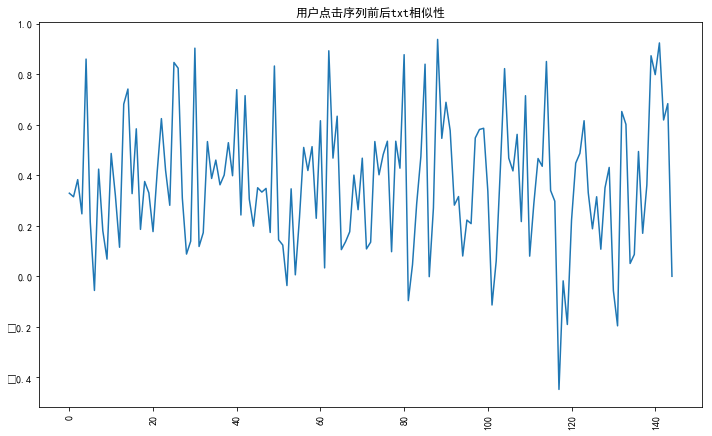

In [13]:
nonull_tmp = tmp[~tmp['txt_vec0'].isnull()]

sim_list = []
for i in range(0, nonull_tmp.shape[0]-1):
    emb1 = nonull_tmp.values[i][-128-128:-128]
    emb2 = nonull_tmp.values[i+1][-128-128:-128]
    sim_list.append(np.dot(emb1,emb2)/(np.linalg.norm(emb1)*(np.linalg.norm(emb2))))
sim_list.append(0)

plt.figure()
plt.figure(figsize=(10, 6))
fig = sns.lineplot(x=[i for i in range(len(sim_list))], y=sim_list)
for item in fig.get_xticklabels():
    item.set_rotation(90)
plt.tight_layout()
plt.title('用户点击序列前后txt相似性')
plt.show()